In [1]:
import numpy as np

In [5]:
### Implementation of 3 PCA methods

DEBUG_PCA = False

variant_names = ['buggy', 'demeaned', 'normalized']
class PCA:

    def __init__(self):
        self.Z = None
        self.V = None
        self.mean = None
        self.std = None
        self.mrv = None # most revent variant

    def train(self, X, d, variant='buggy'):
        self.mrv = variant
        # Function takes a n x D data matrix and d as an argument.
        # It should return the d dimensional representations, the estimated parameters, and the reconstructions of these representations in D dimensions.
        if variant == 'demeaned' or variant == 'normalized':
            # "We subtract the mean along each dimension before applying PCA."
            self.mean = np.mean(X, axis=0)
            X -= self.mean
            if DEBUG_PCA:
                print(f'self.mean={self.mean}')
        
        if variant == 'normalized':
            self.std = np.std(X, axis=0)
            X /= self.std
            if DEBUG_PCA:
                print(f'self.std={self.std}')

        if DEBUG_PCA:
            print(f'Data after initial transformations:')
            print(X[:3])
        
        X_k = np.copy(X)
        if DEBUG_PCA:
            print(f'X_k.shape={X_k.shape}')
        v = []
        for i in range(d):
            matrix_gram = np.matmul(X.T, X)
            eigval, eigvec = np.linalg.eig(matrix_gram)
            idx_vec = np.argmax(eigval)
            vec_max = eigvec[:,idx_vec]
            v.append(vec_max)

            X_k = X_k - np.matmul(X, np.outer(vec_max, vec_max.T))
        self.V = np.array(v)
        if DEBUG_PCA:
            print(f'V.shape={self.V.shape}')

        # store original X points in their Z representation
        # each x_i is 1 x D, so X is n x D
        # each v_j is 1 x D, so V is d x D
        # we want Z which is n x d
        # so we must do Z = X * V^T
        self.Z = np.matmul(X, self.V.T)
        if DEBUG_PCA:
            print(f'Z.shape={self.Z.shape}')

    def reconstruct(self, variant=None):
        if variant is None:
            variant = self.mrv

        # Z is an n x d matrix
        # V is a d x D matrix
        # we want a n x D matrix, hence we must do r = Z @ V
        r =  np.matmul(self.Z, self.V)

        if variant == 'normalized':
            r *= self.std
        if variant == 'demeaned' or variant == 'normalized':
            r += self.mean
        
        return r

In [13]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt


For method buggy, we have

For method demeaned, we have

For method normalized, we have


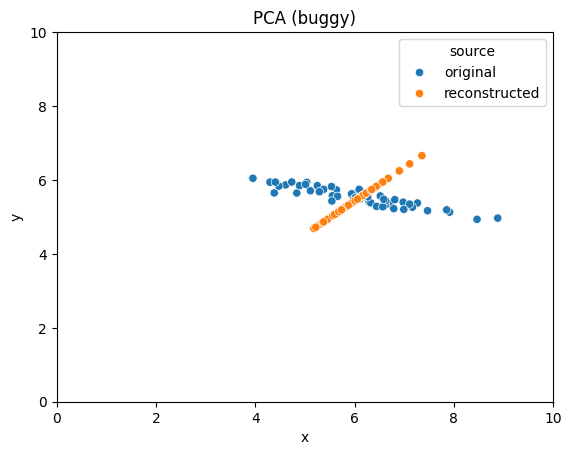

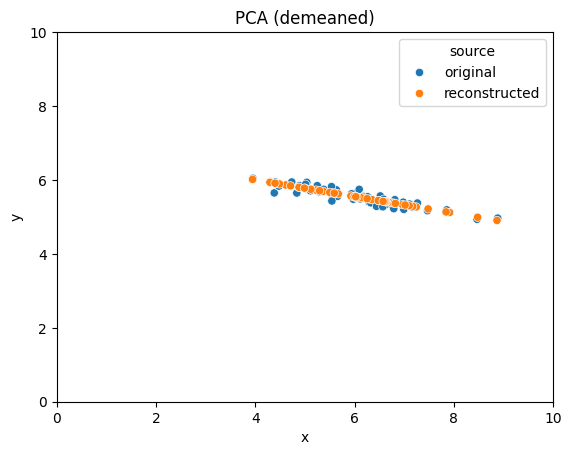

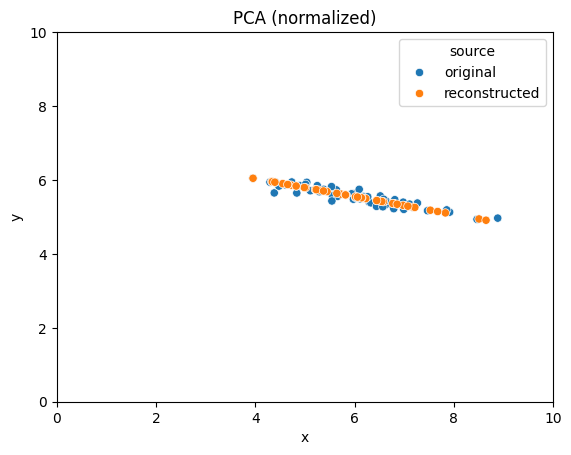

In [18]:
### 3 Plots showing original points and reconstructed points for 2D dataset for each one of the 4 methods

data_2D = np.loadtxt('data/data2D.csv', delimiter=",")

model_PCA = PCA()
for v in variant_names:
    print(f'\nFor method {v}, we have')
    
    # print('First, we train')
    model_PCA.train(np.copy(data_2D), 1, variant=v)
    # print(f'V={model_PCA.V},\nZ={model_PCA.Z[:3]}')
    # print('Then, we reconstruct')
    data_reconstructed = model_PCA.reconstruct()
    # print(data_reconstructed[:3])

    points_combined = np.concatenate((data_2D, data_reconstructed), axis=0)
    # print('points_combined')
    # print(points_combined)
    df = pd.DataFrame(points_combined, columns=['x', 'y'])
    source = ['original' for _ in range(len(data_2D))]
    source.extend(['reconstructed' for _ in range(len(data_2D))])
    df['source'] = source
    # print(df)
    fig, ax = plt.subplots()
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=0, top=10)
    sb.scatterplot(data=df, x="x", y="y", hue="source", ax=ax).set(title=f'PCA ({v})')
    